# CESM Control vs Forcing Runs

How appropriate is it to use the control run as a climatology?

In [1]:
#import my functions
import sys
sys.path.append('../')

import utils._modelDefinitions as _model
import utils.overlapBins as overlapBins

In [2]:
import xarray
import matplotlib.pyplot as plt
import numpy
import scipy.stats

%matplotlib inline

# First, compare the distribution of individual indices

In [3]:
# Here is the data
indecesXr = xarray.open_dataset('../results/cesmTradIndeces.nc').sel(year=slice(850,1849))

indecesXr.experiment.values

array(['LME.002', 'LME.003', 'LME.008', 'LME.009', '0850cntl.001', '001',
       '002', '003', '004', '005', '006', '007', '008', '009', '010',
       '011', '012', '013'], dtype=object)

In [4]:
indecesXr

<xarray.Dataset>
Dimensions:                 (year: 1000, experiment: 18)
Coordinates:
  * year                    (year) int64 850 851 852 853 ... 1846 1847 1848 1849
  * experiment              (experiment) object 'LME.002' 'LME.003' ... '013'
Data variables:
    backgroundSstNoDetrend  (experiment, year) float64 ...
    nino4                   (experiment, year) float64 ...
    westIO                  (experiment, year) float64 ...
    eastIO                  (experiment, year) float64 ...
    nino4NoDetrend          (experiment, year) float64 ...
    samWinter               (experiment, year) float64 ...
    samSummer               (experiment, year) float64 ...
    nino34NoDetrend         (experiment, year) float64 ...
    nino34                  (experiment, year) float64 ...
    dmi                     (experiment, year) float64 ...
    westIONoDetrend         (experiment, year) float64 ...
    eastIONoDetrend         (experiment, year) float64 ...

In [12]:
def chi2Index(indexXr, bins):
    """
    
    This function plots a histogram with the control and the full forcing runs for the input data
    
    """

    #bins=numpy.arange(-2*std, 2.1*std, 0.25*std)

    #calculate histograms using numpy
    cntl=indexXr.sel(experiment=_model.cesmCntl)
    cntlHist, bins = numpy.histogram(cntl, bins=bins)
    mean=indexXr.sel(experiment=_model.cesmFullForcings)
    meanHist, bins = numpy.histogram(mean, bins=bins)

    #plot them on the same axes (as percentage)

    barWidth=0.4*(bins[1]-bins[0])



    plt.bar(bins[:-1],cntlHist/cntlHist.sum()*100, 
            label='cntl', width=-barWidth , align='edge')
    plt.bar(bins[:-1],meanHist/meanHist.sum()*100, 
           label='fullForcing', width=barWidth, align='edge' )

    #plt.ylabel('Frequency (%)')


    plt.title(indexXr.name.capitalize()) #title with the index name
    #plt.legend()


    #Do the Chisquare
    print(
        scipy.stats.chisquare(cntlHist/cntlHist.sum(), meanHist/meanHist.sum() )
    )
        

In [29]:
def chi2Event(xr, x):

    """This function plots the number of events in each compound """
    firePosSum = xr.to_array().sum(dim=['year'])
    
    cntl=firePosSum.sel(variable=x).sel(
        experiment=_model.cesmCntl).values
    fullForcing=firePosSum.sel(variable=x).sel(
        experiment=_model.cesmFullForcings).sum(dim='experiment')/13

    plt.bar(x, cntl/10,  # /1000 years *100 to turn to %
            align='edge', width=-.3, label='cntl'
           )
    plt.bar(x, fullForcing/10, 
            align='edge', width=0.3, label='fullForcing'
           )

    plt.ylabel('Number of events(%)')
    plt.xlabel('Event')
    
    plt.legend()

    print( scipy.stats.chisquare(cntl, f_exp=fullForcing ) )

    
    

Plts of each index in warm season, compared between all forced runs and the control

Power_divergenceResult(statistic=0.011887912302128977, pvalue=0.9999999999482362)
Power_divergenceResult(statistic=0.009946721222624178, pvalue=0.9999999999746101)
Power_divergenceResult(statistic=0.014606567272255889, pvalue=0.9999999998821514)
Power_divergenceResult(statistic=0.008738506529914595, pvalue=0.9999999999848679)


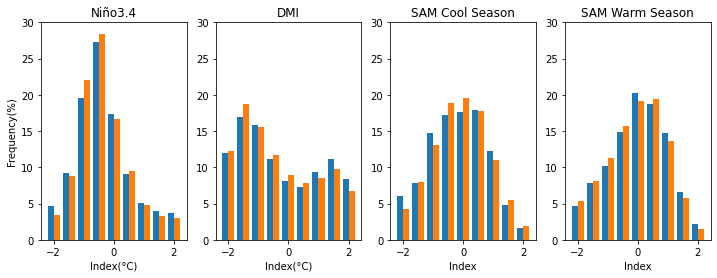

In [14]:

plt.figure(figsize=(12,4))
        
xlabels=['Index(°C)','Index(°C)', 'Index','Index']
indeces=['nino34', 'dmi','samWinter', 'samSummer']
titles=['Niño3.4','DMI','SAM Cool Season','SAM Warm Season']

#For all indices
for i in range(0,4):
    plt.subplot(1,4,i+1)

    chi2Index(indecesXr[indeces[i]], numpy.arange(-2,3,.5) )

    
    #locs, labels = plt.yticks()
    
    #plt.yticks(numpy.arange(0,locs[-1],5))
    plt.title(titles[i])
    plt.xlabel(xlabels[i])
    plt.yticks(numpy.arange(0,35,5))
    
    if i==0:
        plt.ylabel('Frequency(%)')
    
plt.savefig('../figures/cesmControlVsPast1000/warmSeasonIndeces.pdf',bbox_inches='tight')


Comparison of event distribtions 

And for the compounds

In [27]:
#The data
firePos=xarray.open_dataset('../results/cesmFirePos.nc').sel(year=slice(850,1849)).nino34DmiSamsummer.to_dataset('compound')
fireNeg=xarray.open_dataset('../results/cesmFireNeg.nc').sel(year=slice(850,1849)).nino34DmiSamsummer.to_dataset('compound')

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.04325418737345868

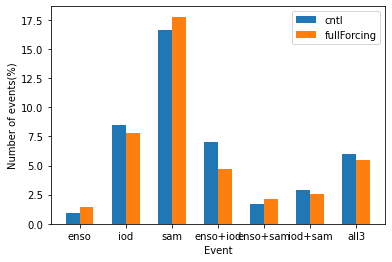

In [30]:
chi2Event(firePos, [*firePos.indeces, *firePos.pairs, 'all3'])


ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.016512870325400726

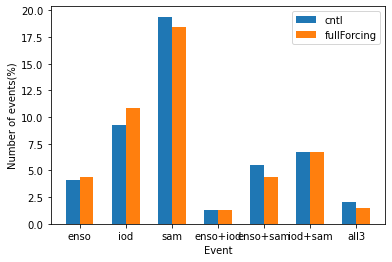

In [31]:
chi2Event(fireNeg, [*fireNeg.indeces, *fireNeg.pairs, 'all3'])

# Plots of frequency of each compound in overlapping 30 year bins

In [32]:
overBinFirePos = overlapBins.binSum(firePos)
overBinFireNeg = overlapBins.binSum(fireNeg)

In [33]:
overBinFireNeg

<xarray.Dataset>
Dimensions:      (year: 97, experiment: 18)
Coordinates:
  * experiment   (experiment) object 'LME.002' 'LME.003' ... '012' '013'
  * year         (year) int64 865 875 885 895 905 ... 1785 1795 1805 1815 1825
Data variables:
    nEvents      (year, experiment) float64 16.0 20.0 18.0 ... 20.0 17.0 21.0
    all3         (year, experiment) float64 0.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    enso+iod     (year, experiment) float64 1.0 0.0 0.0 0.0 ... 0.0 2.0 0.0 2.0
    enso+sam     (year, experiment) float64 4.0 2.0 1.0 0.0 ... 0.0 2.0 2.0 1.0
    iod+sam      (year, experiment) float64 1.0 2.0 2.0 0.0 ... 0.0 1.0 1.0 4.0
    enso         (year, experiment) float64 0.0 0.0 1.0 2.0 ... 0.0 1.0 2.0 1.0
    iod          (year, experiment) float64 3.0 3.0 1.0 3.0 ... 1.0 5.0 5.0 4.0
    sam          (year, experiment) float64 1.0 6.0 7.0 9.0 ... 11.0 4.0 4.0 2.0
    anyCompound  (year, experiment) float64 6.0 5.0 4.0 1.0 ... 0.0 5.0 3.0 7.0
Attributes:
    indexNames:  ['nino34', 'dmi', 'samSummer']
    indeces:     ['enso', 'iod', 'sam']
    pairs:       ['enso+iod', 'enso+sam', 'iod+sam']
    others:      ['all3', 'anyCompound', 'nEvents']
    Bins:        Overlapping 30 year bins, seperating by 10 year intervals
    Year:        Midpoint of bin

In [34]:
overBinFirePos.pairs

['enso+iod', 'enso+sam', 'iod+sam']

Power_divergenceResult(statistic=0.5230713622828567, pvalue=0.9712164628811962)
Power_divergenceResult(statistic=0.0580781810685394, pvalue=0.9713784920201969)
Power_divergenceResult(statistic=0.04227448721602548, pvalue=0.9790845822474958)
Power_divergenceResult(statistic=0.11229670352763074, pvalue=0.9903220051401176)


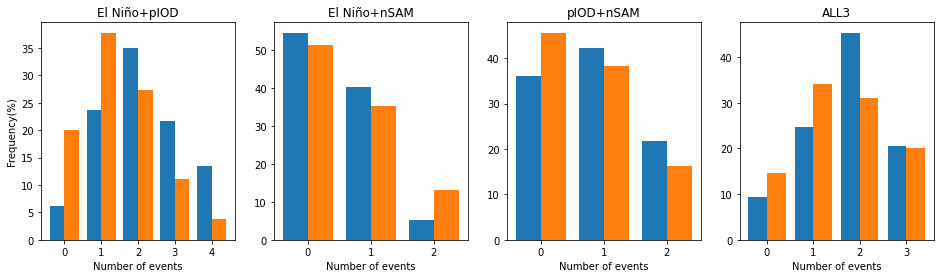

In [44]:
plt.figure(figsize=(16,4))
        
plt.subplot(1,4,1)
chi2Index(overBinFirePos['enso+iod'], 5 )
plt.title('El Niño+pIOD')
plt.xlabel('Number of events')
plt.ylabel('Frequency(%)')

plt.subplot(1,4,2)
chi2Index(overBinFirePos['enso+sam'], 3 )
plt.title('El Niño+nSAM')
plt.xlabel('Number of events')

plt.subplot(1,4,3)
chi2Index(overBinFirePos['iod+sam'], 3 )
plt.title('pIOD+nSAM')
plt.xlabel('Number of events')

plt.subplot(1,4,4)
chi2Index(overBinFirePos['all3'], 4 )
plt.title('ALL3')
plt.xlabel('Number of events')

plt.savefig('../figures/cesmControlVsPast1000/firePos.pdf', bbox_inches='tight')

Power_divergenceResult(statistic=0.01191583645840339, pvalue=0.9940597949702213)
Power_divergenceResult(statistic=0.1536055345346757, pvalue=0.9847065974308311)
Power_divergenceResult(statistic=0.01389517989512736, pvalue=0.9999759769906824)
Power_divergenceResult(statistic=0.08168886254230824, pvalue=0.9599784609607709)


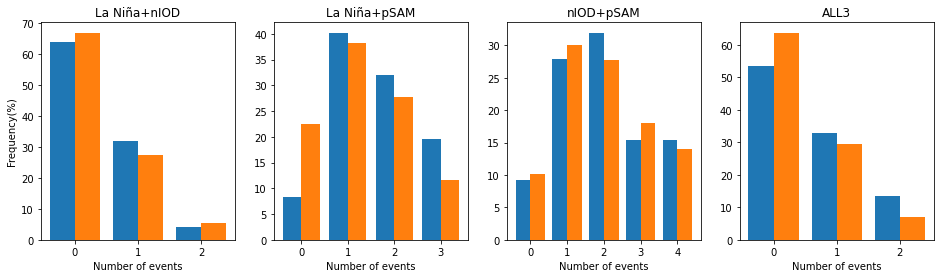

In [46]:
plt.figure(figsize=(16,4))
        
plt.subplot(1,4,1)

chi2Index(overBinFireNeg['enso+iod'], [0,1,2,3] )
plt.title('La Niña+nIOD')
plt.xticks([0,1,2])
plt.xlabel('Number of events')
plt.ylabel('Frequency(%)')

plt.subplot(1,4,2)

chi2Index(overBinFireNeg['enso+sam'], 4 )
plt.title('La Niña+pSAM')
plt.xlabel('Number of events')

plt.subplot(1,4,3)

chi2Index(overBinFireNeg['iod+sam'], 5 )
plt.title('nIOD+pSAM')
plt.xlabel('Number of events')

plt.subplot(1,4,4)

chi2Index(overBinFireNeg['all3'],  [0,1,2,3] )
plt.title('ALL3')
plt.xlabel('Number of events')

plt.savefig('../figures/cesmControlVsPast1000/fireNeg.pdf', bbox_inches='tight')